# Maximum likelihood method to estimate $s$ and $p_0$ using the real aDNA data

Why I'm doing this - previously I used an independent sites simulator and ABC to find a best fitting value of $s$ given the real aDNA data. Since then, filtering of the aDNA changed, so the estimates obtained by ABC are not accurate correct anymore. In fact, I didn't even try to estimate the $s$ precisely, I was exploring a rough grid of different $s$ values to make the job easier.

Luckily, there is another way how to achieve the same thing, more precisely, but without running 100k simulations to estimate $s$. Using the same assumption of selection on independent sites and a little bit of math one can obtain a MLE of the $s$ and initial $p$ in a much simpler and faster way.

In [1]:
library(tidyverse)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


### Function simulating the trajectory of a Nea. allele given $s$, $h$ and $p_0$

This function simulates deterministic selection (no drift) on a single site, starting at a given frequency and operating with a given selection and dominance coefficient.

It simulates selection on a single site, but without any drift and stochasticity. Roughly speaking, it achieves the same thing as the many independent sites simulator earlier, which was taking drift into account but then averaged it out by calculating average Nea. ancestry over all simulated sites.

In [2]:
simulate_selection <- function(p0, s, h, total_time) {
    p_trajectory <- c(p0, rep(0, times=total_time - 1))

    for (gen in seq_len(total_time)[-1]) {
        p <- p_trajectory[gen - 1]
        
        # fitness values of all three genotypes
        fitnesses <- c(p ^ 2           * (1 + s),
                       2 * p * (1 - p) * (1 + h * s),
                       (1 - p) ^ 2     * 1)

        # mean fitness of the whole population
        mean_fitness <- sum(fitnesses)
        
        # relative fitness values of all three genotypes
        rel_fitnesses <- fitnesses / mean_fitness
        
        p_trajectory[gen] <- rel_fitnesses[1] + 0.5 * rel_fitnesses[2]
    }
    p_trajectory
}

Testing the function on an example from the Gillespie's book (also slide 7 [here](http://content.csbs.utah.edu/~rogers/ant5221/lecture/selection.pdf)). He simulates haploid selection with s=0.1, but we get the same result by simulating diploid selection with s=0.2 (because selection in diploids proceeds 2X slower).

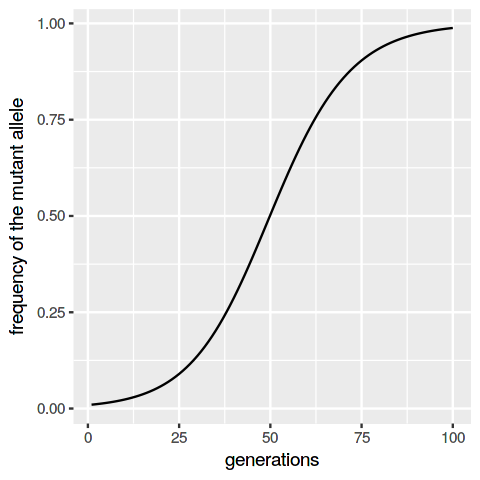

In [3]:
options(repr.plot.width=4, repr.plot.height=4)

gen <- 100
traj <- simulate_selection(p0=0.01, s=0.2, h=0.5, total_time=gen)

qplot(x=1:gen, y=traj, geom="line", xlab="generations", ylab="frequency of the mutant allele")

## Example of the ML procedure on simulated data

#### Function to approximate noisy aDNA samples

Given a vector of times in generations and a simulated trajectory of Nea. ancestry proportions calculated using `simulate_selection` function we sample individual datapoints (aDNA individuals) at each specified time point (in generations after admixture).

The way it works is that we take the simulated Nea. trajectory at each time as a parameter $p$ in the binomial distribution, and sample from this binomial distribution `snp_count` SNPs and calculate the mean Nea. ancestry from these SNPs. This introduces a little bit of noise, approximating the noisy aDNA data we have.

In [4]:
sample_datapoints <- function(sample_times, traj, snp_count) {
    data.frame(
        nea=sapply(sample_times,
                   function(gen) {
                       mean(rbinom(snp_count, 1, traj[gen])) 
                   }),
        snp_count=snp_count,
        gen=sample_times
    )
}

Simulation of the trajectory of Nea. ancestry given (given $p_0$, $s$ and $h$) and sampling "aDNA samples" from this trajectory. We can see that the noisiness of the simulated data corresponds quite well to what we see in the real data.

In [25]:
total_time <- 2200 # generations
sample_times <- sort(sample(1:2200, 20)) # ages of the 20 aDNA samples

p0 <- 0.04   # initial Nea. frequency
s <- -0.0006 # selection coefficient
h <- 0.5     # dominance coefficient

# simulate the selection against Nea. alleles with arbitrarily chosen
# parameters
traj <- simulate_selection(p0, s, h, total_time)

# sample aDNA samples
aDNA_samples <- sample_datapoints(sample_times, traj, snp_count=8000)

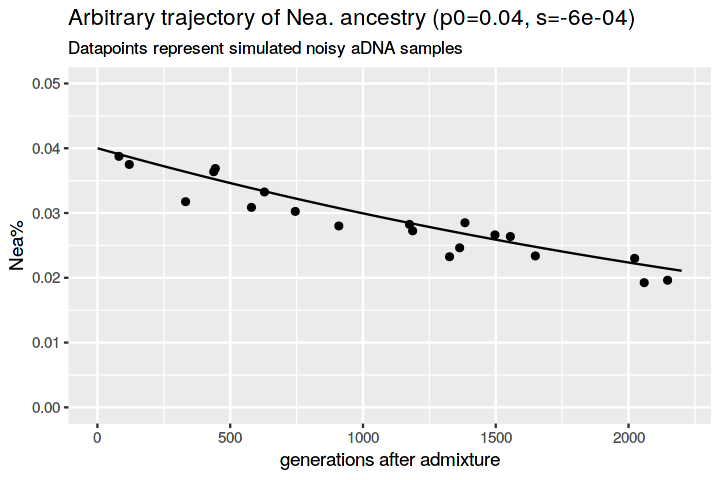

In [26]:
options(repr.plot.width=6, repr.plot.height=4)

# plot the simulated trajectory of Nea. ancestry together with
# the simulated "aDNA samples"
qplot(1:total_time, traj, geom="line", ylab="Nea%", xlab="generations after admixture", ylim=c(0, 0.05)) +
    geom_point(aes(gen, nea), data=aDNA_samples) +
    ggtitle(label=paste0("Arbitrary trajectory of Nea. ancestry (p0=", p0, ", s=", s, ")"),
            subtitle="Datapoints represent simulated noisy aDNA samples")

## Maximum likelihood method to fit $s$ and $p_0$ from the simulated data

We assume $h = 0.5$ and admixture 55 kya.

The idea is to find the set of parameters that maximize the likelihood of aDNA samples given the Nea. trajectory determined by these parameters.

### Negative log-likelihood function of the parameters $s$ and $p_0$ given aDNA data

The likelihood of each aDNA Neanderthal ancestry estimate is calculated as if it was drawn from a binomial distribution, with a parameter $p$ representing a Nea. ancestry value at a given time. Likelihoods of all samples are then combined together to generate a combined negative log-likelihood.

The number of SNPs available for each sample is taken into account during the binomial likelihood calculation (less SNPs available means higher tolerance for deviation from the Nea. ancestry value predicted by $p_0$ and $s$ in each iteration).

In [27]:
negLL <- function(param, real_data) {
    # parameters of the model
    p0 <- param[1] # initial Nea. ancestry
    s <- param[2]  # selection coefficient
    
    # simulate the Nea. ancestry trajectory determined by the parameters
    # and subset to the values corresponding to time points of the aDNA
    # samples
    sim_data <- as.vector(simulate_selection(p0,
                                             s,
                                             0.5,
                                             total_time=2200)[real_data$gen])
    
    # calculate the negative log-likelihoods of each individual aDNA point
    # (the number of Nea-like SNPs observed on all SNPs available for the sample)
    # given the parameters (actually, given the Nea. trajectory determined
    # by the parameters)
    -sum(dbinom(as.integer(real_data$nea * real_data$snp_count),
                real_data$snp_count,
                sim_data, log=TRUE))
}

In [35]:
# minimize the negative log-likelihood function
# start from arbitrary initial Nea 10% and s=-0.1
results <- optim(c(0.1, -0.1), negLL, real_data=aDNA_samples)

**MLE values** of the $p_0$ and $s$:

In [36]:
(mle_p0 <- results$par[1])
(mle_s <- results$par[2])

[1] 0.03885273

[1] -0.0006134836

**Original values** of the $p_0$ and $s$ for comparison:

In [37]:
p0
s

[1] 0.04

[1] -6e-04

Yay! It works!

## Maximum likelihood estimation of $s$ and $p_0$ using the real aDNA data

In [38]:
estimates <- read_tsv("../output/nea_estimates.txt") %>% mutate(gen=as.integer((55000 - age) / 25))

Parsed with column specification:
cols(
  name = col_character(),
  nea = col_double(),
  age = col_integer(),
  snp_count = col_integer()
)


In [39]:
head(estimates)

name,nea,age,snp_count,gen
UstIshim,0.02834072,45020,479930,399
Kostenki14,0.02656486,37470,400947,701
GoyetQ116_1,0.02880845,34795,97356,808
Muierii2,0.02226141,33300,14154,868
Vestonice13,0.02894517,30870,23091,965
Vestonice16,0.02552449,30010,172180,999


In [40]:
results <- optim(c(0.1, -0.01), negLL, real_data=estimates)

**MLE values** of the $p_0$ and $s$:

In [41]:
(mle_p0 <- results$par[1])
(mle_s <- results$par[2])

[1] 0.03121932

[1] -0.0004701649

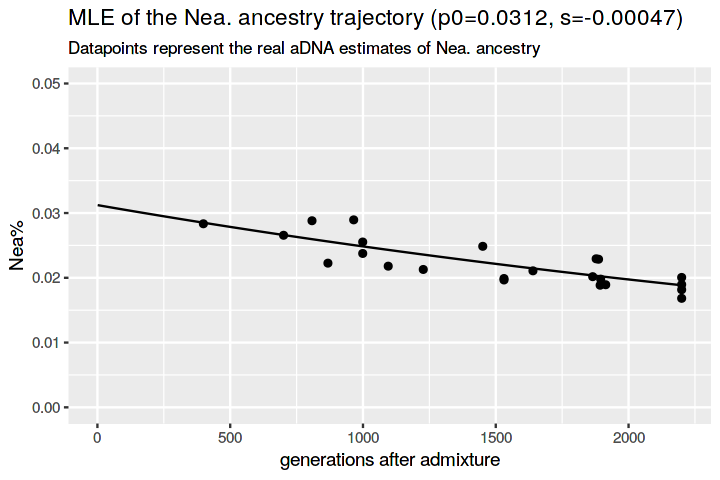

In [42]:
options(repr.plot.width=6, repr.plot.height=4)

total_time <- 2200 # generations

# simulate the selection against Nea. alleles using the MLE of parameters
mle_traj <- simulate_selection(mle_p0, mle_s, 0.5, total_time)

# plot the simulated trajectory of Nea. ancestry together with
# the simulated "aDNA samples"
qplot(1:total_time, mle_traj, geom="line", ylab="Nea%", xlab="generations after admixture", ylim=c(0, 0.05)) +
    geom_point(aes(gen, nea), data=estimates) +
    ggtitle(label=paste0("MLE of the Nea. ancestry trajectory (",
                         "p0=", round(mle_p0, digits=4), ", ",
                         "s=", round(mle_s, digits=5), ")"),
            subtitle="Datapoints represent the real aDNA estimates of Nea. ancestry")